# Walk Foward Evaluation

This section mimics a real-life like approach, where a model is trained on a week worth of data, and then used to predict 7 days worth of predictions.

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [22]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
# pandas
import pandas as pd
from pandas.plotting import lag_plot
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import r2_score
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# plaidml keras
import plaidml.keras
plaidml.keras.install_backend()
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.15.4
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.20.2
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [23]:
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=13 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
nrows=1000000
bin_value = 2
if bin_value < 2:
    raise ValueError('Number of buckets must be greater than 1')
test_split=.5 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA','IOWAIT_DELTA'] # Denotes which label to use for time series experiments

# Feature Selection
parallel_degree = -1

# LSTM Network Structure
epochs=150
batch=32
activation='sigmoid'
initializer='uniform'
dropout=0
layer=1
state=False

### Read data from file into Pandas Dataframes

In [24]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, nrows=nrows)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, nrows=nrows)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [25]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape) + '\n')

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)
print(rep_hist_snapshot_df.shape)
print(rep_hist_sysmetric_summary_df.shape)
print(rep_hist_sysstat_df.shape)

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (12067, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (6212, 163)
Table [REP_HIST_SYSSTAT] - (849, 1180)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'PLAN_HASH_VALUE' 'OPTIMIZER_COST'
 'OPTIMIZER_ENV_HASH_VALUE' 'SHARABLE_MEM' 'LOADED_VERSIONS'
 'VERSION_COUNT' 'SQL_PROFILE' 'PARSING_SCHEMA_ID' 'PARSING_USER_ID'
 'FETCHES_TOTAL' 'FETCHES_DELTA' 'END_OF_FETCH_COUNT_TOTAL'
 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL' 'SORTS_DELTA' 'EXECUTIONS_TOTAL'
 'EXECUTIONS_DELTA' 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA'
 'LOADS_TOTAL' 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DE

### Dealing with Empty Values

In [26]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 77: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND CHECKPOINTS PER SEC', 'BACKGROUND TIME PER SEC', 'BRANCH NODE SPLITS PER SEC', 'BRANCH NODE SPLITS PER TXN', 'CPU USAGE PER SEC', 'CPU USAGE PER TXN', 'CR BLOCKS CREATED PER SEC', 'CR BLOCKS CREATED PER TXN', 'CR UNDO RECORDS APPLIED PER SEC', 'CR UNDO RECORDS APPLIED PER TXN', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'CONSISTENT READ CHANGES PER SEC', 'CONSISTENT READ CHANGES PER TXN', 'CONSISTENT READ GETS PER SEC', 'CONSISTENT READ GETS PER TXN', 'CURRENT LOGONS COUNT', 'CURRENT OS LOAD', 'CURRENT OPEN CURSORS COUNT', 'CURSOR CACHE HIT RATIO', 'DB BLOCK CHANGES PER SEC', 'DB BLOCK CHANGES PER TXN', 'DB BLOCK CHANGES PER USER CALL', 'DB BLOCK GETS PER SEC', 'DB BLOCK GETS PER TXN', 'DB BLOCK GETS PER U

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [27]:
print
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(849, 1418)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLSEX

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [28]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(849, 1418)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [29]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(849, 1418)


### Redundant Feature Removal

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [30]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(849, 1418)

Shape before changes: [(849, 1418)]
Shape after changes: [(849, 514)]
Dropped a total [904]

After flatline column drop:
(849, 514)

After additional column drop:
(849, 504)


### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [31]:
def get_outliers_quartile(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            q25, q75 = np.percentile(df[header], 25), np.percentile(df[header], 75)
            iqr = q75 - q25
            cut_off = iqr * .6 # This values needs to remain as it. It was found to be a good value so as to capture the relavent outlier data
            lower, upper = q25 - cut_off, q75 + cut_off
           
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
           
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
   
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows

#Printing outliers to screen
outliers = get_outliers_quartile(df=df,
                                 headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']')
    
def edit_outliers(df=None, headers=None):
    """
    This method uses the interquartile method to edit all outliers to std.
    """
    outliers = get_outliers_quartile(df=df,
                                     headers=y_label)
    for label in y_label:
        min_val = df[label].min()
        max_val = df[label].max()
        mean_val = df[label].mean()
        std_val = df[label].std()
       
        for i in range(len(outliers)):
            if label == outliers[i][0]:
                df[label].iloc[outliers[i][1]] = mean_val + std_val
                # print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']')
    return df

print("DF with outliers: " + str(df.shape))
df = edit_outliers(df=df,
                   headers=y_label)
print("DF with edited outliers: " + str(df.shape))

CPU_TIME_DELTA - [0] outliers
IOWAIT_DELTA - [115] outliers
Total Outliers: [115]

Label[CPU_TIME_DELTA] - Min[5939253] - Max[1270731887] - Mean[488446071.19787985] - Std[455933579.5953747]
Label[IOWAIT_DELTA] - Min[123115.0] - Max[969154123.0] - Mean[20458818.64664311] - Std[58751329.898645945]

---------------------------------------------

Header [IOWAIT_DELTA] - Location [7] - Value [45906216.0]
Header [IOWAIT_DELTA] - Location [8] - Value [54738912.0]
Header [IOWAIT_DELTA] - Location [9] - Value [38384072.0]
Header [IOWAIT_DELTA] - Location [20] - Value [54155590.0]
Header [IOWAIT_DELTA] - Location [21] - Value [45285285.0]
Header [IOWAIT_DELTA] - Location [32] - Value [54160781.0]
Header [IOWAIT_DELTA] - Location [33] - Value [45329000.0]
Header [IOWAIT_DELTA] - Location [44] - Value [45636547.0]
Header [IOWAIT_DELTA] - Location [45] - Value [48079360.0]
Header [IOWAIT_DELTA] - Location [56] - Value [36417586.0]
Header [IOWAIT_DELTA] - Location [57] - Value [58425620.0]
Header [I

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


DF with edited outliers: (849, 504)


### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [32]:
class Normalizer:

    @staticmethod
    def robust_scaler(dataframe):
        """
        Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
        normalization of values.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.robust_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def minmax_scaler(dataframe):
        """
        Normalize df using min-max ranges for normalization method
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.minmax_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def normalize(dataframe):
        """
        The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.normalize(dataframe.values)
        return pd.DataFrame(X, columns=headers)

print('------------------BEFORE------------------')
print('------------------DF------------------')
print(df.shape)
print('\n')
#print(df.head())
#
# ROBUST SCALER
# df = Normalizer.robust_scaler(dataframe=df)
#
# MINMAX SCALER
df = Normalizer.minmax_scaler(dataframe=df)
#
# NORMALIZER
#df = Normalizer.normalize(dataframe=df)

print('\n\n------------------AFTER------------------')
print('------------------df------------------')
print(df.shape)
print('\n\n')
print('\n\ndf')
print(df.head())

------------------BEFORE------------------
------------------DF------------------
(849, 504)




------------------AFTER------------------
------------------df------------------
(849, 504)





df
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000    1.837222e-09      0.585105       0.691327       0.121617   
1  0.001179    4.117775e-02      0.601268       0.826501       0.053256   
2  0.002358    4.117776e-02      0.692164       0.823089       0.667477   
3  0.003538    4.117776e-02      0.697532       0.824362       0.757211   
4  0.004717    4.117776e-02      0.760445       0.826007       0.686924   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.251834                  0.044969     0.082830   
1                  0.820719                  0.054400     0.794497   
2                  0.761584                  0.572676     0.808928   
3                  0.778333                  0.680617     0.813788   
4 

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [33]:
y_df = df[y_label]
X_df = df.drop(columns=y_label)
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(X_df.shape))
print(X_df.head())

Label ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] shape: (849, 2)
Feature matrix shape: (849, 502)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000    1.837222e-09      0.585105       0.691327       0.121617   
1  0.001179    4.117775e-02      0.601268       0.826501       0.053256   
2  0.002358    4.117776e-02      0.692164       0.823089       0.667477   
3  0.003538    4.117776e-02      0.697532       0.824362       0.757211   
4  0.004717    4.117776e-02      0.760445       0.826007       0.686924   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.251834                  0.044969     0.082830   
1                  0.820719                  0.054400     0.794497   
2                  0.761584                  0.572676     0.808928   
3                  0.778333                  0.680617     0.813788   
4                  0.795525                  0.613982     0.809686   

   SORTS_DELTA  EXECUTIONS_TOTAL      

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [34]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    #     for header in headers:
    #         if "(t)" in header:
    #             dropped_headers.append(header)

    for i in range(1, n + 1):
        for header in headers:
            if "(t+" + str(i) + ")" in header:
                dropped_headers.append(str(header))

    return df.drop(dropped_headers, axis=1)


# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)

# Separate labels from features
y_row = []
for i in range(lag + 1, (lag * 2) + 2):
    y_df_column_names = shifted_df.columns[len(df.columns) * i:len(df.columns) * i + len(y_label)]
    y_row.append(y_df_column_names)
    print(y_df_column_names)
    print(type(y_df_column_names))
y_df_column_names = []
for row in y_row:
    for val in row:
        y_df_column_names.append(val)

# y_df_column_names = shifted_df.columns[len(df.columns)*lag:len(df.columns)*lag + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df.drop(columns=y_df_column_names)
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)

# # Delete middle timesteps
# X_df = remove_n_time_steps(data=X_df, n=lag)
# print('\n-------------\nFeatures After Time Shift')
# print(X_df.columns)
# print(X_df.shape)
# y_df = remove_n_time_steps(data=y_df, n=lag)
# print('\n-------------\nLabels After Time Shift')
# print(y_df.columns)
# print(y_df.shape)

Index(['var1(t+1)', 'var2(t+1)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+2)', 'var2(t+2)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+3)', 'var2(t+3)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+4)', 'var2(t+4)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+5)', 'var2(t+5)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+6)', 'var2(t+6)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+7)', 'var2(t+7)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+8)', 'var2(t+8)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+9)', 'var2(t+9)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+10)', 'var2(t+10)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+11)', 'var2(t+11)'], dtype='object')
<class 'pandas.core.indexes.base.Ind

### Feature Selection

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [35]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, parallel_degree=1, max_depth=None, max_features='sqrt', n_estimators=100):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :param max_depth:             (Integer) Denotes number of leaves to evaluate during decision tree pruning.
        :param max_features:          (Integer) Denotes number of features to consider during random subselection.
        :param n_estimators:          (Integer) Number of estimators (trees) to build for decision making.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df[self.__y_df.columns[0]].values  # We can only use a single target column since RandomForests do not support multi target labels
        print(X_df.shape)
        print(y_df.shape)
        optimum_feature_count = int(optimum_feature_count)
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                            y_df, 
                                                            test_size=test_split)
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      n_jobs=parallel_degree,
                                      max_depth=max_depth,
                                      max_features='sqrt')

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]
    
# fe = FeatureEliminator(X_df=X_df,
#                        y_df=y_df)
# column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
#                                                optimum_feature_count=X_df.shape[1]/4,
#                                                parallel_degree=parallel_degree,
#                                                max_depth=None,
#                                                max_features='sqrt',
#                                                n_estimators=X_df.shape[1]*2)
# print(X_df.columns)
# X_df = fe.get_selected_features(column_mask=column_mask)
# print(X_df.columns)

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

    var1(t-13)    var2(t-13)  var3(t-13)  var4(t-13)  var5(t-13)  var6(t-13)  \
13    0.000000  1.837222e-09    0.585105    0.691327    0.121617    0.251834   
14    0.001179  4.117775e-02    0.601268    0.826501    0.053256    0.820719   
15    0.002358  4.117776e-02    0.692164    0.823089    0.667477    0.761584   
16    0.003538  4.117776e-02    0.697532    0.824362    0.757211    0.778333   
17    0.004717  4.117776e-02    0.760445    0.826007    0.686924    0.795525   

    var7(t-13)  var8(t-13)  var9(t-13)  var10(t-13)      ...       \
13    0.044969    0.082830    0.918550     0.193098      ...        
14    0.054400    0.794497    0.054651     0.835819      ...        
15    0.572676    0.808928    0.365388     0.788224      ...        
16    0.680617    0.813788    0.420214     0.801313      ...        
17    0.613982    0.809686    0.350324     0.815205      ...        

    var495(t+13)  var496(t+13)  var497(t+13)  var498(t+13)  var499(t+13)  \
13      0.026713      0.0315

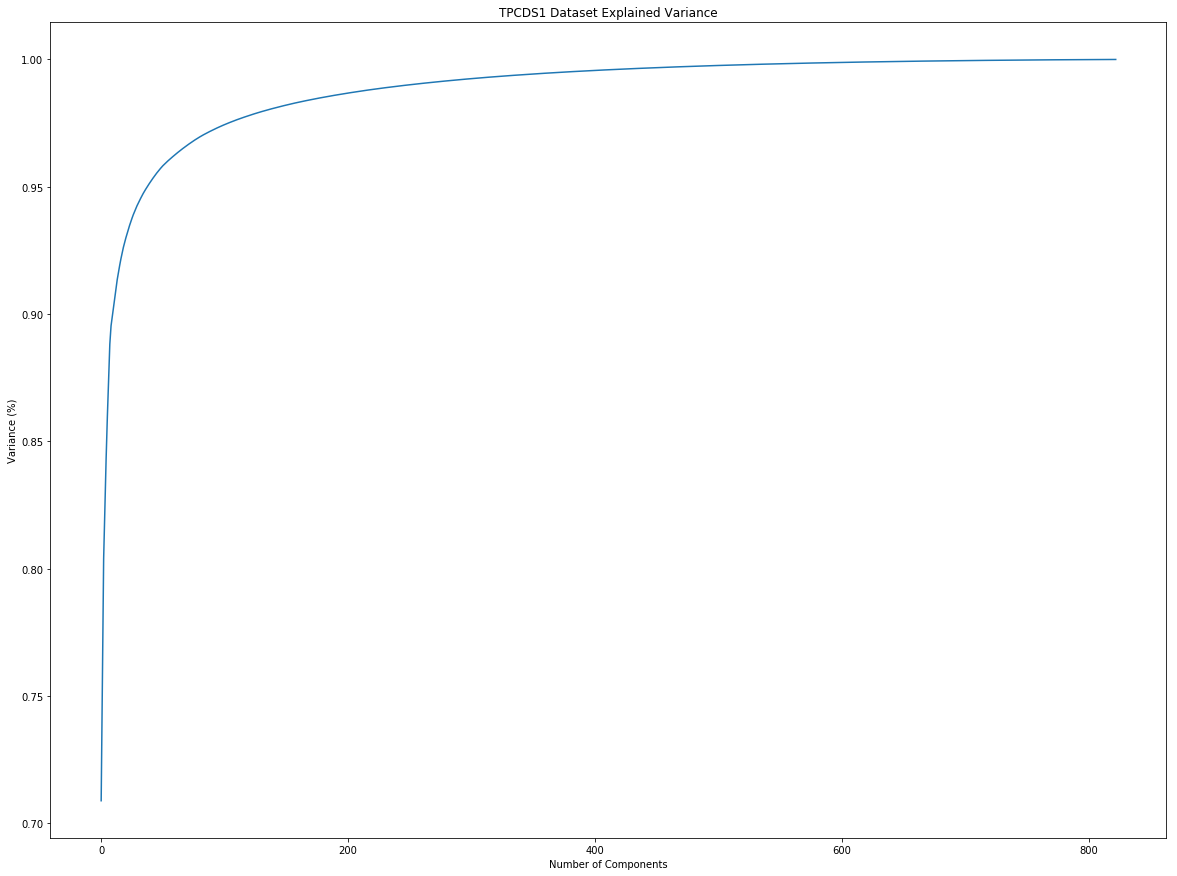

------------------------------
   Component_0  Component_1  Component_2  Component_3  Component_4  \
0    43.641356     5.187547    -9.276417    -5.068237     4.464304   
1    43.594852    -5.260333    -9.119132     3.870354     5.232812   
2    43.517217   -10.878147    -0.202004     5.450979    -3.057377   
3    43.404294    -5.924347     9.469530    -2.478154    -5.001100   
4    43.268647     5.106617     9.988520    -5.122026     1.984724   

   Component_5  Component_6  Component_7  Component_8  Component_9  \
0    -1.138424    -5.181744    -1.513825     0.157177     4.149492   
1    -0.905290    -3.239018    -3.778836     0.121665    -1.696338   
2    -0.848172    -1.457950    -4.916702     0.097200    -1.075549   
3    -0.849520     0.714358    -4.688688     0.169105     3.227549   
4    -0.748332     3.385278    -3.469658     0.160902    -1.154928   

       ...        Component_239  Component_240  Component_241  Component_242  \
0      ...             0.176599       0.137268 

In [36]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(X_df.head())
print(X_df.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df.head())
print(X_df.shape)

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [37]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets. This class needs
    to be defined before the LSTM class, since it is referenced during the prediction stage. Since Keras models output a
    continuous output (even when trained on discrete data), the 'BinClass' is required by the LSTM class.
    """

    @staticmethod
    def __validate(df, n):
        """
        Validates class parameters
        """
        if df is None:
            raise ValueError('Input data parameter is empty!')
        elif n < 2:
            raise ValueError('Number of buckets must be greater than 1')

    @staticmethod
    def __bucket_val(val, threshold, n):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        for i in range(1, n+1):
            if val <= threshold * i:
                return i-1

    @staticmethod
    def discretize_value(X, n):
        """
        param: X - Input data
        param: n - Number of buckets
        """
        if len(X.shape) == 1:
            X = X.reshape(-1, 2)

        for i in range(X.shape[1]):
            max_val = X[:, i].max()
            threshold = max_val / n
            myfunc_vec = np.vectorize(lambda x: BinClass.__bucket_val(x, threshold, n))
            X[:, i] = myfunc_vec(X[:, i])
        return X

## LSTM Classification (Many to Many)
### Designing the network

- The first step is to define your network.
- Neural networks are defined in Keras as a sequence of layers. The container for these layers is the **Sequential class**.
- The first step is to create an instance of the Sequential class. Then you can create your layers and add them in the order that they should be connected.
- The LSTM recurrent layer comprised of memory units is called LSTM().
- A fully connected layer that often follows LSTM layers and is used for outputting a prediction is called Dense().
- The first layer in the network must define the number of inputs to expect.
- Input must be three-dimensional, comprised of samples, timesteps, and features.
    - **Samples:** These are the rows in your data.
    - **Timesteps:** These are the past observations for a feature, such as lag variables.
    - **Features:** These are columns in your data.
- Assuming your data is loaded as a NumPy array, you can convert a 2D dataset to a 3D dataset using the reshape() function in NumPy.

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
* https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://arxiv.org/pdf/1312.6026.pdf
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

In [38]:
# LSTM Class
class LSTM:
    """
    Long Short Term Memory Neural Net Class
    """

    def __init__(self, X, y, lag, loss_func, activation, mode='regression', optimizer='sgd', lstm_layers=1, dropout=.0,
                 stateful=False, y_labels=None, initializer='uniform'):
        """
        Initiating the class creates a net with the established parameters
        :param X             - (Numpy 2D Array) Training data used to train the model (Features).
        :param y             - (Numpy 2D Array) Test data used to test the model (Labels
        :param lag           - (Integer) Denotes lag step value
        :param loss_function - (String)  Denotes mode of measure fitting of model (Fitting function).
        :param activation    - (String)  Neuron activation function used to activate/trigger neurons.
        :param mode          - (String)  A flag used to set specific model training mode (Classification OR Regression).
        :param optimizer     - (String)  Denotes which function to us to optimize the model build (eg: Gradient Descent).
        :param lstm_layers   - (Integer) Denotes the number of LSTM layers to be included in the model build.
        :param dropout       - (Float)   Denotes amount of dropout for model. This parameter must be a value between 0 and 1.
        :param stateful      - (Boolean) Denotes whether state is used as initial state for next training batch.
        :param: y_labels     - (List) List of target label names
        :param: initializer  - (String)  String initializer which denotes starting weights.
        """
        self.mode = mode
        self.__lag = lag
        self.__model = ke.models.Sequential()
        self.__y_labels = y_labels

        if dropout > 1 and dropout < 0:
            raise ValueError('Dropout parameter exceeded! Must be a value between 0 and 1.')
        
        # self.__model.add(ke.layers.Embedding(2+1, 32, input_length=X.shape[1]))
        for i in range(0, lstm_layers - 1):  # If lstm_layers == 1, this for loop logic is skipped.
            if stateful:
                if i == 0:
                    self.__model.add(ke.layers.LSTM(X.shape[2],
                                                    batch_input_shape=(X.shape[0],
                                                                       X.shape[1],
                                                                       X.shape[2]),
                                                    return_sequences=True,
                                                    recurrent_dropout=dropout,
                                                    recurrent_initializer=initializer,
                                                    activation=activation,
                                                    stateful=stateful))
                else:
                    self.__model.add(ke.layers.LSTM(X.shape[2],
                                                    input_shape=(X.shape[1],
                                                                 X.shape[2]),
                                                    return_sequences=True,
                                                    recurrent_dropout=dropout,
                                                    recurrent_initializer=initializer,
                                                    activation=activation,
                                                    stateful=stateful))
            else:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                input_shape=(X.shape[1],
                                                             X.shape[2]),
                                                return_sequences=True,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                stateful=stateful))
            self.__model.add(ke.layers.Dropout(dropout))
        if lstm_layers > 1:
            self.__model.add(ke.layers.LSTM(X.shape[2],
                                            input_shape=(X.shape[1],
                                                         X.shape[2]),
                                            stateful=stateful,
                                            recurrent_dropout=dropout,
                                            recurrent_initializer=initializer,
                                            activation=activation,
                                            return_sequences=False))
        else:
            if stateful:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                batch_input_shape=(X.shape[0],
                                                                   X.shape[1],
                                                                   X.shape[2]),
                                                stateful=stateful,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                return_sequences=False))
            else:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                input_shape=(X.shape[1],
                                                             X.shape[2]),
                                                stateful=stateful,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                return_sequences=False))
        self.__model.add(ke.layers.Dropout(dropout))
        # self.__model.add(ke.layers.TimeDistributed(ke.layers.Dense(self.__lag * len(self.__y_labels), kernel_initializer=initializer)))
        self.__model.add(ke.layers.Dense(self.__lag * len(self.__y_labels),
                                         kernel_initializer=initializer,
                                         activation='sigmoid'))
        self.__model.compile(loss=loss_func, optimizer=optimizer, metrics=['acc'])
        print(self.__model.summary())

    def fit_model(self, X_train=None, X_test=None, y_train=None, y_test=None, epochs=50, batch_size=50, verbose=2,
                  shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.

        :param: X_train    - (Numpy 2D Array) Numpy matrix consisting of input training features
        :param: X_test     - (Numpy 2D Array) Numpy matrix consisting of input validation/testing features
        :param: y_train    - (Numpy 2D Array) Numpy matrix consisting of output training labels
        :param: y_test     - (Numpy 2D Array) Numpy matrix consisting of output validation/testing labels
        :param: epochs     - (Integer) Integer value denoting number of trained epochs
        :param: batch_size - (Integer) Integer value denoting LSTM training batch_size
        :param: verbose    - (Integer) Integer value denoting net verbosity (Amount of information shown to user during LSTM training)
        :param: shuffle    - (Bool) Boolean value denoting whether or not to shuffle data. This parameter must always remain 'False' for time series datasets.
        :param: plot       - (Bool) Boolean value denoting whether this function should plot out it's evaluation

        :return: None
        """
        if X_test is not None and y_test is not None:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_data=(X_test, y_test),
                                       verbose=verbose,
                                       shuffle=shuffle)
        else:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       verbose=verbose,
                                       shuffle=shuffle)

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            if self.mode == 'regression':
                plt.plot(history.history['loss'], label='train')
                plt.plot(history.history['val_loss'], label='validation')
            elif self.mode == 'classification':
                plt.plot(history.history['acc'], label='train')
                plt.plot(history.history['val_acc'], label='validation')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

    def predict(self, X, batch_size):
        """
        Predicts label/s from input feature 'X'
        :param: X - Numpy matrix consisting of a single feature vector
        :param: batch_size - (Integer) Denotes prediction batch size
        :return: Numpy matrix of predicted label output
        """
        yhat = self.__model.predict(X, batch_size=batch_size)
        return yhat

    def evaluate(self, y, yhat, plot=False):
        """
        Receives 2D matrix of input features and 2D matrix of output labels, and evaluates input data and target predictions.
        :param: y    - Numpy array consisting of output label vectors (Test Set)
        :param: yhat - Numpy array consisting of output label vectors (Prediction Set)
        :param: plot     - (Bool) Boolean value denoting whether this function should plot out it's evaluation
        :return: None
        """
        # RMSE Evaluation
        if self.mode == 'regression':
            rmse = math.sqrt(mean_squared_error(y, yhat))
            if not plot:
                return rmse
            print('Reported: ' + str(rmse) + ' rmse')

        elif self.mode == 'classification':
            column_names = []
            for i in range(len(self.__y_labels)):
                column_names.append("column" + str(i))

            y = BinClass.discretize_value(y, bin_value)
            yhat = BinClass.discretize_value(yhat, bin_value)
            y = y.flatten()
            yhat = yhat.flatten()

            # F1-Score Evaluation
            print(y)
            print(yhat)
            accuracy = accuracy_score(y, yhat)
            f1 = f1_score(y,
                          yhat,
                          average='binary')  # Calculate metrics globally by counting the total true positives, false negatives and false positives.
            #print('Accuracy [' + str(accuracy) + ']')
            #print('FScore [' + str(f1) + ']')

            if not plot:
                return accuracy, f1

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(y, label='actual')
            plt.plot(yhat, label='predicted')
            plt.legend(['actual', 'predicted'], loc='upper left')
            plt.title('Actual vs Predicted')
            plt.show()

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, batch, dropout, epoch, layer, activation, initializer,
                              stateful, rmse, accuracy, f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained LSTM models, each denoted with different configurations.

        Attempted configurations:
        * Varied data test split
        * Varied batch sizes
        * Varied epoch counts

        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path       - (String) String denoting result csv output.
        :param: iteration  - (Integer) Integer denoting test iteration (Unique per test configuration).
        :param: lag        - (Integer) Denotes lag time shift
        :param: test_split - (Float) Float denoting data sample sizes.
        :param: batch      - (Integer) Integer denoting LSTM batch size.
        :param: epoch      - (Integer) Integer denoting number of LSTM training iterations.
        :param: layer      - (Integer) Integer denoting number of LSTM layers
        :param: activation - (String) String denoting activation for LSTM layers.
        :param: initializer- (String) String denoting LSTM initializing weights.
        :param: stateful   - (Bool) Boolean flag which denotes whether LSTM model is trained in stateful mode or not.
        :param: dropout    - (Float) Float denoting model dropout layer.
        :param: rmse       - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy   - (Float) Float denoting experiment accuracy score.
        :param: fscore     - (Float) Float denoting experiment fscore score.
        :param: time_train - (Integer) Integer denoting number of seconds taken by LSTM training iteration.

        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a+') as csvfile:
            headers = ['iteration', 'test_split', 'batch', 'epoch', 'layer', 'stateful', 'dropout', 'activation',
                       'initializer', 'rmse', 'accuracy', 'f_score', 'time_train', 'lag']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'test_split': test_split,
                             'batch': batch,
                             'epoch': epoch,
                             'layer': layer,
                             'stateful': stateful,
                             'dropout': dropout,
                             'activation': activation,
                             'initializer': initializer,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train,
                             'lag': lag})

    @staticmethod
    def lag_multiple(X, lag):
        """
        Divides the total number of rows by the lag value, until a perfect multiple amount is retrieved.
        :param X: (Numpy) 2D array consisting of input.
        :param lag: (Integer) Denotes time shift value.
        :return: (Numpy) 2D array consisting of a perfect lag multiple rows.
        """
        n_rows = X.shape[0]
        multiple = int(n_rows/lag)
        max_new_rows = multiple * lag
        return X[0:max_new_rows, :]

### Data Encoding

Encoding data into binary classification problem

In [39]:
X_df = pd.DataFrame(BinClass.discretize_value(X_df.values, bin_value), columns=X_df.columns)
y_df = pd.DataFrame(BinClass.discretize_value(y_df.values, bin_value), columns=y_df.columns)
print(np.unique(X_df.values))
print(np.unique(y_df.values))

X_df = X_df.apply(LabelEncoder().fit_transform)
y_df = y_df.apply(LabelEncoder().fit_transform)
print(np.unique(X_df.values))
print(np.unique(y_df.values))
print('X:')
print(np.count_nonzero(X_df == 0))
print(np.count_nonzero(X_df == 1))
print('y:')
print(np.count_nonzero(y_df == 0))
print(np.count_nonzero(y_df == 1))

[0. 1.]
[0. 1.]
[0 1]
[0 1]
X:
196912
8015
y:
15893
5505


## LSTM Training (Week Prior: Day 1 - 7)

An LSTM model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.


Reshaping Training Frames
X_train shape [(31, 13, 249)] Type - <class 'numpy.ndarray'>
y_train shape [(31, 26)] Type - <class 'numpy.ndarray'>
X_validate shape [(31, 13, 249)] Type - <class 'numpy.ndarray'>
y_validate shape [(31, 26)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 249)               497004    
_________________________________________________________________
dropout_2 (Dropout)          (None, 249)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 26)                6500      
Total params: 503,504
Trainable params: 503,504
Non-trainable params: 0
_________________________________________________________________
None
Train on 31 samples, validate on 31 samples
Epoch 1/150
 - 8s - loss: 0.6879 - acc: 0.5533 - val_loss: 0.6549 - val_acc: 0.7146


Epoch 86/150
 - 0s - loss: 0.1260 - acc: 0.9938 - val_loss: 0.4264 - val_acc: 0.6675
Epoch 87/150
 - 0s - loss: 0.1211 - acc: 0.9938 - val_loss: 0.4478 - val_acc: 0.6799
Epoch 88/150
 - 0s - loss: 0.1161 - acc: 0.9888 - val_loss: 0.4334 - val_acc: 0.6638
Epoch 89/150
 - 0s - loss: 0.1103 - acc: 0.9938 - val_loss: 0.4382 - val_acc: 0.6687
Epoch 90/150
 - 0s - loss: 0.1050 - acc: 0.9938 - val_loss: 0.4550 - val_acc: 0.6749
Epoch 91/150
 - 0s - loss: 0.1005 - acc: 0.9938 - val_loss: 0.4366 - val_acc: 0.7060
Epoch 92/150
 - 0s - loss: 0.0957 - acc: 0.9938 - val_loss: 0.4561 - val_acc: 0.6737
Epoch 93/150
 - 0s - loss: 0.0904 - acc: 0.9938 - val_loss: 0.4551 - val_acc: 0.6650
Epoch 94/150
 - 0s - loss: 0.0855 - acc: 0.9938 - val_loss: 0.4456 - val_acc: 0.7097
Epoch 95/150
 - 0s - loss: 0.0814 - acc: 0.9938 - val_loss: 0.4728 - val_acc: 0.6873
Epoch 96/150
 - 0s - loss: 0.0772 - acc: 0.9938 - val_loss: 0.4508 - val_acc: 0.7134
Epoch 97/150
 - 0s - loss: 0.0727 - acc: 0.9938 - val_loss: 0.464

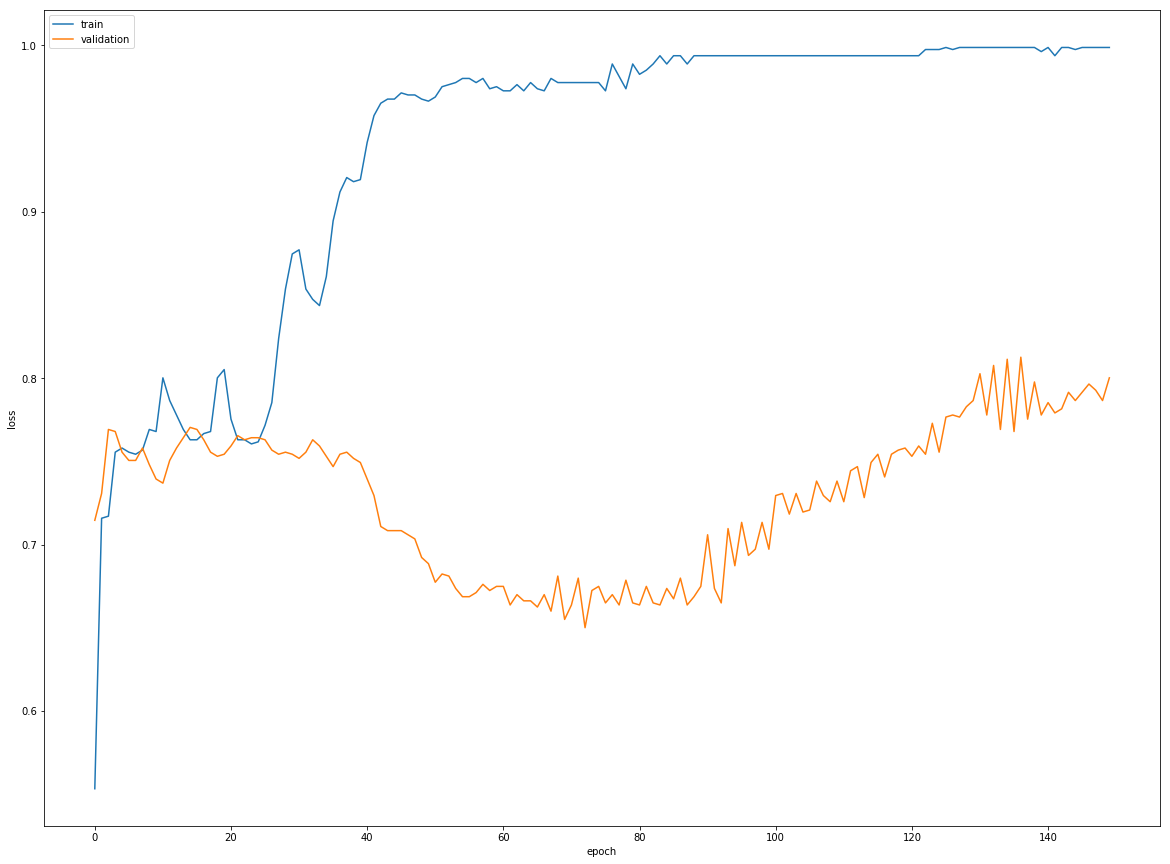

Wall time: 13.6 s


In [40]:
%%time
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=lag)
y_train = LSTM.lag_multiple(X=y_train, lag=lag)
X_validate = LSTM.lag_multiple(X=X_validate, lag=lag)
y_validate = LSTM.lag_multiple(X=y_validate, lag=lag)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / lag), lag, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / lag),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / lag), lag, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / lag),:]                    

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='binary_crossentropy',
             activation=activation,
             optimizer='adam',
             mode='classification',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

## LSTM Validation: Day 8 - 14

Evaluating model fit to day 1 forecasts. 

In [41]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    acc_list, f_list = [], []
    for i in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[i,:]))
        X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = model.predict(X, batch_size=batch)
        
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=5, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        acc_score, f_score = model.evaluate(y=np.array(y_validate_temp[i, :]),
                                            yhat=y,
                                            plot=False)
        acc_list.append(acc_score)
        f_list.append(f_score)
    
    daily_acc = sum(acc_list) / len(acc_list)
    daily_fscore = sum(f_list) / len(f_list)
    accuracy_per_day.append(daily_acc)
    f1score_per_day.append(daily_fscore)
    print('Accuracy: ' + str(daily_acc) + '\nF1 Score: ' + str(daily_fscore))
    print('-'*40)

Day 1
Feature vectors: (4, 13, 249)
Label vectors: (4, 26)
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Accuracy: 0.375
F1 Score: 0.5
----------------------------------------
Day 2
Feature vectors: (4, 13, 249)
Label vectors: (4, 26)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Accuracy: 0.25
F1 Score: 0.3333333333333333
----------------------------------------
Day 3
Feature vectors: (4, 13, 249)
Label vectors: (4, 26)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Accuracy: 0.125
F1 Score: 0.16666666666666666
----------------------------------------
Day 4
Feature vectors: (4, 13, 249)
Label vectors: (4, 26)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Accuracy: 0.25
F1 Score: 0.3333333333333333
----------------------------------------
Day 5
Feature vectors: (4, 13, 249)
Label vectors: (4, 26)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Accuracy: 0.25
F1 Score: 0.3333333333333333
----------------------------------------
Day 6
Feature vectors: (4, 13, 249)
Label vectors: (4, 26)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Accuracy: 0.375
F1 Score: 0.5
----------------------------------------
Day 7
Feature vectors: (4, 13, 249)
Label vectors: (4, 26)
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Accuracy: 0.375
F1 Score: 0.5
------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


### Scoring per day

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

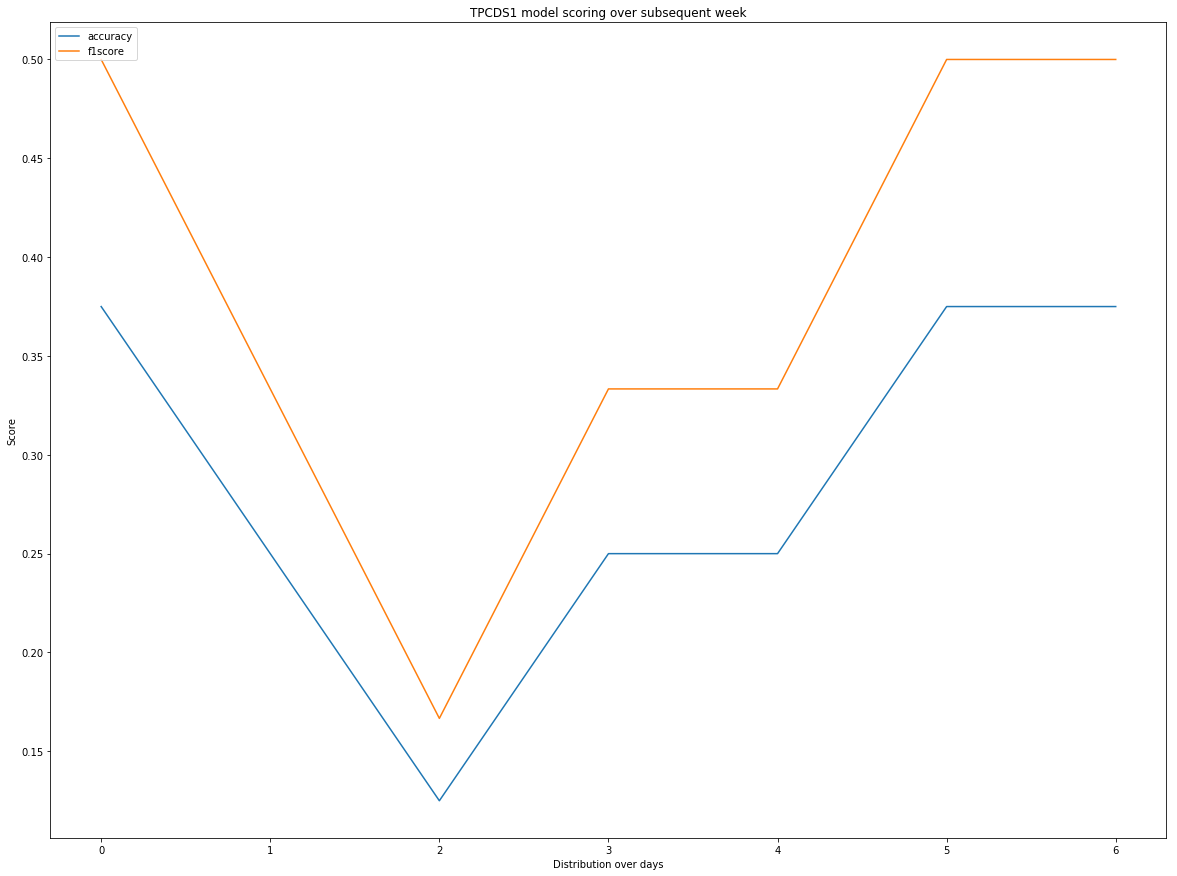

In [42]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()